## 📘 Movie Dataset Analysis Using PySpark

## 1. Introduction

This project analyzes the MovieLens movie dataset using PySpark.
The objective is to apply big data processing and machine learning techniques
to analyze movie metadata, build regression models, and develop a recommendation system.

The dataset contains metadata for approximately 45,000 movies released
on or before July 2017, including budget, revenue, vote averages, and user ratings.

This project fulfills the course learning outcomes related to Big Data processing,
Spark MLlib, and real-world data analysis.


 ## 2. Environment Setup & Spark Initialization

In [1]:
import os
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_extract, year, coalesce, lit, expr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from recommender import train_als_safe, evaluate_als, get_top_n_similar_movies, predict_user_ratings
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s")

spark = SparkSession.builder \
    .appName("Movie Dataset Analysis") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/21 14:59:20 WARN Utils: Your hostname, sakhawat, resolves to a loopback address: 127.0.1.1; using 10.147.169.209 instead (on interface wlp3s0)
25/12/21 14:59:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/21 14:59:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 3. Data Loading

The dataset files are loaded using Spark DataFrame APIs.


In [2]:
data_dir = "data"

movies = spark.read.csv(
    os.path.join(data_dir, "movies_metadata.csv"),
    header=True,
    inferSchema=True
)

ratings = spark.read.csv(
    os.path.join(data_dir, "ratings.csv"),
    header=True,
    inferSchema=True
)


## 4. Data Preprocessing

Invalid movie IDs are removed, numeric columns are safely cast,
and missing values are handled to prepare the data for modeling.


In [3]:
movies = movies.withColumn(
    "movieId",
    regexp_extract(col("id"), r"^\d+$", 0)
).filter(col("movieId") != "") \
 .withColumn("movieId", col("movieId").cast("int"))

numeric_cols = ["budget", "revenue", "vote_average", "vote_count"]
for c in numeric_cols:
    movies = movies.withColumn(c, expr(f"try_cast({c} AS DOUBLE)"))

from pyspark.sql.functions import when

movies = movies.withColumn(
    "release_year",
    when(
        col("release_date").rlike("^[0-9]{4}-[0-9]{2}-[0-9]{2}$"),
        year(expr("to_date(release_date, 'yyyy-MM-dd')"))
    ).otherwise(None)
)

movies_reg = movies.select(
    "budget",
    "vote_count",
    "release_year",
    "revenue",
    "vote_average"
).where(
    col("release_year").isNotNull()
).na.drop().cache()


In [4]:
ratings = ratings.select(
    col("userId").cast("int"),
    col("movieId").cast("int"),
    col("rating").cast("float")
).na.drop().cache()


## 5. Regression Models

Linear Regression models are built to predict:
1. Movie revenue
2. Movie vote average

Evaluation is performed using RMSE.


In [5]:
def train_regression(features, label):
    assembler = VectorAssembler(
        inputCols=features,
        outputCol="features"
    )
    data = assembler.transform(movies_reg) \
        .select("features", col(label).alias("label"))

    train, test = data.randomSplit([0.8, 0.2], seed=42)

    lr = LinearRegression()
    model = lr.fit(train)

    predictions = model.transform(test)
    evaluator = RegressionEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="rmse"
    )

    return evaluator.evaluate(predictions)


In [6]:
rmse_revenue = train_regression(
    ["budget", "vote_count", "release_year"],
    "revenue"
)

rmse_vote = train_regression(
    ["budget", "vote_count", "release_year"],
    "vote_average"
)

print(f"Revenue Prediction RMSE: {rmse_revenue:.2f}")
print(f"Vote Average Prediction RMSE: {rmse_vote:.2f}")


25/12/21 15:00:11 WARN Instrumentation: [0e6bb78d] regParam is zero, which might cause numerical instability and overfitting.
25/12/21 15:00:14 WARN Instrumentation: [6dcc7aea] regParam is zero, which might cause numerical instability and overfitting.


Revenue Prediction RMSE: 30140344.34
Vote Average Prediction RMSE: 1.92


## 6. Vote Average Analysis

Data visualization is used to analyze factors affecting movie vote averages.


In [7]:
movies_pd = movies_reg.select(
    "budget", "vote_count", "vote_average", "release_year"
).toPandas()

movies_pd = movies_pd[movies_pd["release_year"] > 0]


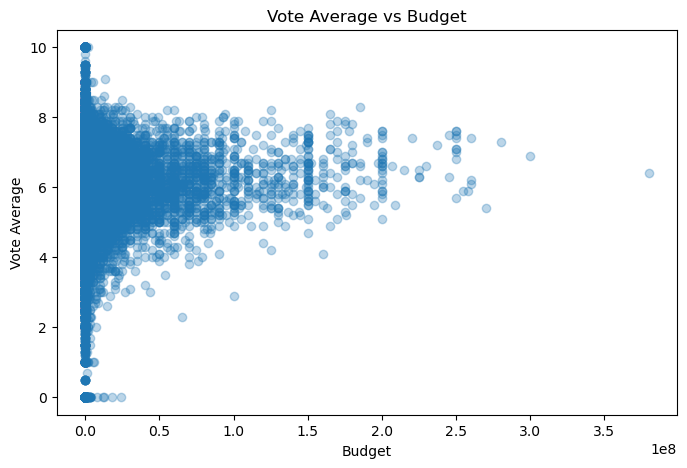

In [8]:
plt.figure(figsize=(8,5))
plt.scatter(movies_pd["budget"], movies_pd["vote_average"], alpha=0.3)
plt.xlabel("Budget")
plt.ylabel("Vote Average")
plt.title("Vote Average vs Budget")
plt.show()


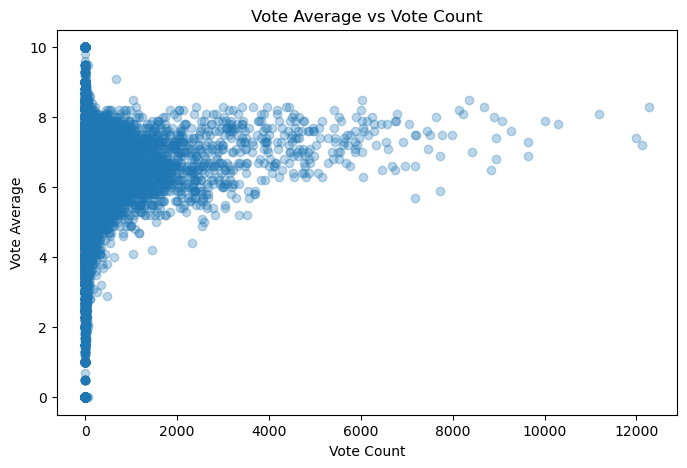

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(movies_pd["vote_count"], movies_pd["vote_average"], alpha=0.3)
plt.xlabel("Vote Count")
plt.ylabel("Vote Average")
plt.title("Vote Average vs Vote Count")
plt.show()


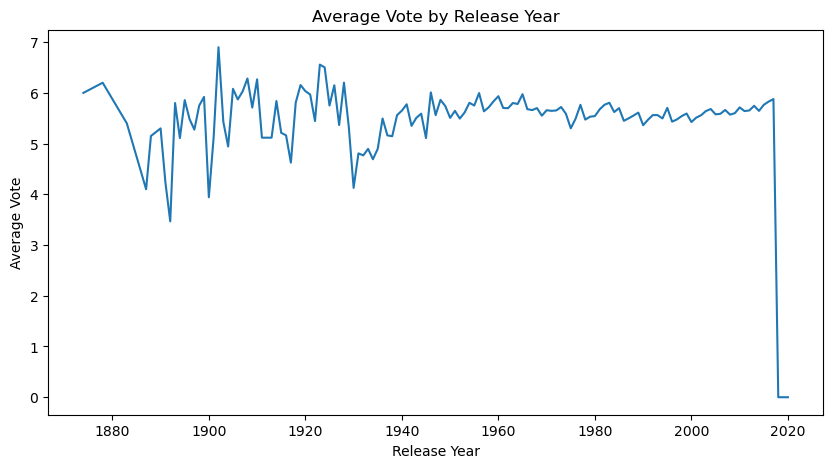

In [10]:
avg_vote_year = movies_pd.groupby("release_year")["vote_average"].mean()

plt.figure(figsize=(10,5))
avg_vote_year.plot()
plt.xlabel("Release Year")
plt.ylabel("Average Vote")
plt.title("Average Vote by Release Year")
plt.show()


## 7. Recommendation System

Collaborative filtering using ALS is applied to build a movie recommender system.


In [11]:
als_model = train_als_safe(ratings)
evaluate_als(als_model, ratings)


2025-12-21 15:00:35,639 [INFO] Total ratings rows: 26024289                     
2025-12-21 15:00:35,639 [WARNING] Sampling 1000000 rows from 26024289 for memory safety
2025-12-21 15:00:49,113 [INFO] ALS model trained successfully.                  
2025-12-21 15:01:05,172 [INFO] ALS Model RMSE: 1.0705                           


1.070492106984657

### 7.1 Top-N Similar Movies


In [12]:
movie_title = "The Godfather"

similar_movies = get_top_n_similar_movies(
    movie_title,
    movies,
    als_model,
    top_n=10
)

if similar_movies:
    similar_movies.show(truncate=False)


+--------------------+-------+
|title               |movieId|
+--------------------+-------+
|Mister Roberts      |37853  |
|The War of the Roses|249    |
|Meet the Fockers    |693    |
|The Reaping         |1683   |
+--------------------+-------+



### 7.2 User Rating Prediction


In [13]:
user_id = 1

all_movies = movies.select("movieId").distinct()
rated = ratings.filter(col("userId") == user_id).select("movieId")

unrated = all_movies.join(
    rated,
    on="movieId",
    how="left_anti"
)

predictions = predict_user_ratings(
    user_id,
    unrated,
    als_model
)

predictions.show(10, truncate=False)


+-------+----------+
|movieId|prediction|
+-------+----------+
|1115   |5.9319654 |
|42094  |5.3025417 |
|134238 |5.244342  |
|2830   |5.1819105 |
|72899  |5.1383524 |
|52088  |5.083516  |
|3934   |5.0308867 |
|2923   |5.0230713 |
|27922  |4.9971895 |
|32689  |4.9819417 |
+-------+----------+
only showing top 10 rows


## 8. Conclusion

The regression models demonstrate that budget and vote count significantly
influence movie revenue and vote averages. Visualization results show that
movies with higher audience engagement tend to receive higher ratings.

The collaborative filtering system successfully recommends similar movies
and predicts unseen user ratings using large-scale data.


In [14]:
spark.stop()